# estimating the psd using Voytek (2015) methods

This notebook demonstrates how to compute the PSD for a full recording of resting-state eyes closed and eyes open EEG using 2-second segments with 50% overlap.

In [40]:
%matplotlib inline
import os
import glob
import seaborn
import numpy as np
import scipy as sp
import pandas as pd
import scipy.ioth=
import numpy.fft
import scipy.signal
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import linregress
mpl.rcParams['figure.figsize'] = (16, 10)

In [2]:
data = sp.io.loadmat('../data/pipeline-full/oaExclFiltCARClust-mat/120127163.mat')
events = []
for event in np.squeeze(data['evts']):
     events.append([event[0][0], event[1][0][0], event[2][0][0]])
srate = data['srate'][0][0]
data  = np.squeeze(data['data'])

def import_subjects(import_path):
    subj = {}
    matfiles = []
    for root, dirs, files in os.walk(import_path):
        matfiles += glob.glob(os.path.join(root, '*.mat'))
    for i in range(len(matfiles)):
        datafile = sp.io.loadmat(matfiles[i])
        subj[i] = {}
        subj[i]['name'] = str(np.squeeze(datafile['name']))
        subj[i]['data'] = np.squeeze(datafile['data'])
    return subj

In [28]:
def split_segs(x, nperseg=1024, noverlap=512):
    segs = []
    nsegs = (len(x)//noverlap) - 1
    for i in range(nsegs):
        segs.append(x[i*noverlap : i*noverlap + nperseg])
    return segs

def get_segs(data, seg_ranges, srate=512, nperseg=1024, noverlap=512):
    """ 
    Given a time series and a list of valid ranges from which to
    extract data, return segments of data.
    """
    segs = []
    for seg in seg_ranges:
        if seg[1] >= nperseg:
            found_segs = split_segs(data[seg[0] : seg[0] + seg[1]])
            for s in found_segs:
                segs.append(s)
    return segs

c_segs = []
for i in range(len(events)):
    if events[i][0] == 'C1':
        c_segs.append([events[i][1], events[i+1][1] - events[i][1]])

total_length = 0
for seg in c_segs:
    total_length += seg[1]
    print(seg)
print('Total length, points:  ', total_length)
print('Total length, seconds: ', total_length/512)

[61346, 2181]
[63886, 4336]
[71011, 2514]
[74211, 1868]
[89880, 2037]
[92767, 2566]
[97828, 2743]
[102830, 1737]
[140797, 1770]
[143142, 3559]
[149568, 2990]
[153382, 2011]
[208861, 2880]
[218011, 1861]
Total length, points:   35053
Total length, seconds:  68.462890625


First, let's extract as many 2-second segments from the recording as we can.

In [29]:
segs = get_segs(data[0], c_segs)

In [32]:
hamming = []
for s in segs:
    hamming.append(s * sp.signal.hamming(len(s)))

In [34]:
dft = []
for s in hamming:
    dft.append( sp.signal.welch(s, fs=512, nperseg=1024, noverlap=0, window='hamming') )

In [36]:
final = np.mean([seg[1] for seg in dft], axis=0)

(0, 60)

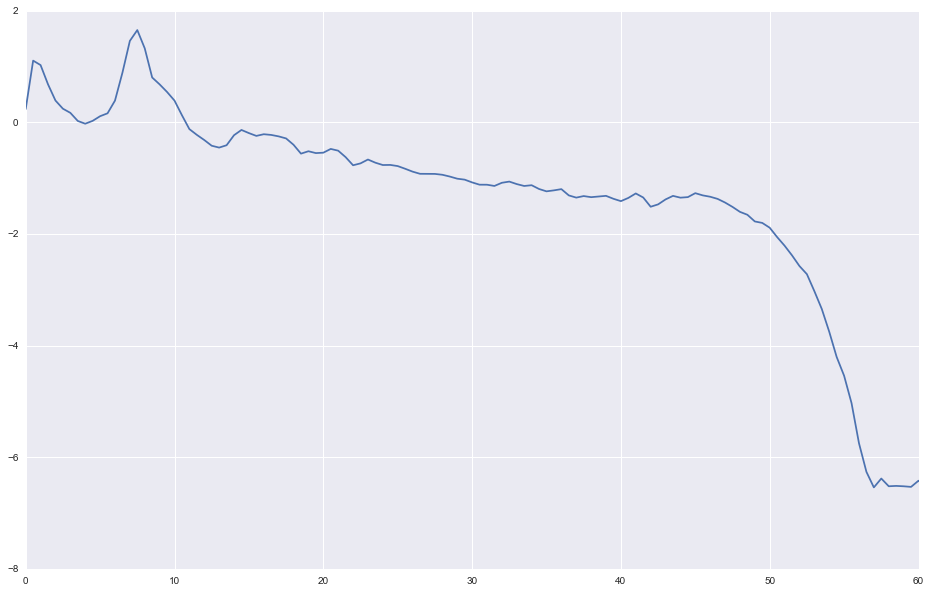

In [41]:
plt.plot(dft[0][0], np.log10(final)); plt.xlim([0, 60])